# Valasztas 2018

## Választási adatok importálása:

'wget -mkEpnp https://static.valasztas.hu/dyn/pv18/szavossz/hu/start.html'

In [9]:
import glob
from bs4 import BeautifulSoup
import pandas as pd
from tabulate import tabulate
from io import StringIO
import matplotlib.pyplot as plt

In [41]:
path = 'static.valasztas.hu/dyn/pv18/szavossz/hu/'
files = glob.glob(path + '/**/szkjkv_*.html', recursive=True)
numofszavazokor = 10285

if (len(files) == numofszavazokor):
    print(len(files), " szavazókör adatai beolvasva.")
    print("Szavazókör eredmények beolvasása sikeres.")
else:
    print(len(files), " szavazókör adatai beolvasva.")
    print(numofszavazokor - len(files), " szavazókör adatai hiányoznak.")

    print("Szavazókör eredmények beolvasása sikertelen.")

10285  szavazókör adatai beolvasva.
Szavazókör eredmények beolvasása sikeres.


In [22]:
def process_html(filename):
    inputfile = open(filename, encoding="utf8")
    html = inputfile.read()
    html = html.replace("&nbsp;","")
    soup = BeautifulSoup(html,'lxml')

    tags=soup.find_all()
    for tag in tags:
        if tag.has_attr('style'):
            del tag.attrs['style']
        
    h2 = soup.find_all('h2')
    tables = soup.find_all('table')

    return h2, tables

def process_header(h2):
    szavazokor = None
    valasztokerulet = None
    tipus = None
    h2_0 = h2[0].get_text().split("\n")
    match h2_0[0]:
        case "Szavazóköri eredmények":
            tipus = "normal"
        case "Szavazóköri eredmények az egy szavazókörös településen és a kijelölt szavazókörben":
            tipus = "egyszavazokoros"
        case "Szavazóköri eredmények az átjelentkezéssel és a külföldön leadott szavazatok megszámlálásárakijelölt szavazókörben":
            tipus = "atjelentkezeses"            
    szavazokor = h2_0[1].replace(".számú szavazókör","")        
    valasztokerulet = (h2[1].get_text()).replace(".számú egyéni választókerületi szavazás","")
    return szavazokor, valasztokerulet, tipus   

def show_results(filename):
    data = pd.read_html(filename)
    for table in data:
        display(table)

def show_results_html(filename):
    h2, data = process_html(filename)
    for table in data:
        display(table)    

def process_azonositok(tables, tipus):
    teljes = None
    szavazott = None
    reszvetel = None
    ervenyes = None
    table2 = pd.read_html(StringIO(str(tables[2])), header=0)
    table3 = pd.read_html(StringIO(str(tables[3])), header=0)
    table4 = pd.read_html(StringIO(str(tables[4])), header=0)
    table2_values = table2[0].values
    table3_values = table3[0].values
    table4_values = table4[0].values
    
    if (tipus == "normal" and table2_values[0][0]=='AE' and table2_values[0][1]=='FE' and table3_values[0][4]=='NE'):
        teljes = int(table2_values[1][0])
        szavazott = int(table2_values[1][1].split(" ")[0])
        reszvetel = float(table2_values[1][1].split(" ")[1])
        ervenyes = int(table3_values[1][4])
    elif (tipus == "atjelentkezeses" and table2_values[0][3]=='EE' and table3_values[0][2]=='JE' and table4_values[0][4]=='NE'):
        teljes = int(table2_values[1][3])
        szavazott = int(table3_values[1][2].split(" ")[0])
        reszvetel = float(table3_values[1][2].split(" ")[1])
        ervenyes = int(table4_values[1][4])
    elif (tipus == "egyszavazokoros" and table2_values[0][0]=='AE' and table2_values[0][1]=='FE' and table4_values[0][5]=='NE'):
        teljes = int(table2_values[1][0])
        szavazott = int(table2_values[1][1].split(" ")[0])
        reszvetel = float(table2_values[1][1].split(" ")[1])
        ervenyes = int(table4_values[1][5])

    return teljes, szavazott, reszvetel, ervenyes

def process_eredmenyek(tables, ervenyes):
    osszefogas = 0
    fidesz_kdnp = 0
    jobbik = 0
    mszp_p = 0
    dk = 0

    for index, table in enumerate(tables):
        if (index >= 2):
            tabledata = pd.read_html(StringIO(str(table)), header=0)
            headercell = tabledata[0].columns.values[1]
            match headercell:
                case 'A jelölt neve':
                    tabledata[0].drop(tabledata[0].columns[[0,1]], inplace=True, axis=1)
                    egyeni = tabledata[0]
                    if ervenyes > 0:                
                        for i in egyeni.values:
                            if (i[0] == 'FIDESZ-KDNP'):
                                fidesz_kdnp = (i[1]/ervenyes)*100
                            elif (i[0] == 'JOBBIK'):
                                jobbik = (i[1]/ervenyes)*100
                            elif (i[0] == 'MSZP-PÁRBESZÉD'):
                                mszp_p = (i[1]/ervenyes)*100
                            elif (i[0] == 'ÖSSZEFOGÁS PÁRT'):
                                osszefogas = (i[1]/ervenyes)*100
                            elif (i[0] == 'DK'):
                                dk = (i[1]/ervenyes)*100
                case 'A pártlista neve' | 'A pártlista neve, azonosítója':                    
                    tabledata[0].drop(tabledata[0].columns[[0]], inplace=True, axis=1)
                    listas = tabledata[0]
                case _:
                    empty = None
    return egyeni, listas, fidesz_kdnp, jobbik, mszp_p, osszefogas, dk

def process_file(filename):
    h2, tables = process_html(filename)
    szavazokor, valasztokerulet, tipus = process_header(h2)    
    teljes, szavazott, reszvetel, ervenyes = process_azonositok(tables, tipus)
    egyeni, listas, fidesz_kdnp, jobbik, mszp_p, osszefogas, dk = process_eredmenyek(tables, ervenyes)
    return valasztokerulet, szavazokor, tipus, teljes, szavazott, reszvetel, ervenyes, egyeni, listas, fidesz_kdnp, jobbik, mszp_p, osszefogas, dk   

def calculate_frequency(df):
    df_cleaned = df.to_frame(name='x').query("x >= 1")['x']
    df_rounded = df_cleaned.round().astype(int)	
    return (df_rounded.value_counts()).sort_index()

In [7]:
filename = 'static.valasztas.hu/dyn/pv18/szavossz/hu/M07/T106/szkjkv_001.html'
#filename = 'static.valasztas.hu/dyn/pv18/szavossz/hu/M07/T028/szkjkv_003.html'
#filename = 'static.valasztas.hu/dyn/pv18/szavossz/hu/M07/T094/szkjkv_091.html'
#filename = 'static.valasztas.hu/dyn/pv18/szavossz/hu/M07/T108/szkjkv_002.html'
#show_results(filename)

eredmenyek = pd.DataFrame(columns= ('valasztokerulet', 'szavazokor', 'tipus', 'filename', 'teljes', 'szavazott', 'reszvetel', 'ervenyes', 'fidesz-kdnp', 'jobbik', 'mszp-p', 'osszefogas', 'dk'))

valasztokerulet, szavazokor, tipus, teljes, szavazott, reszvetel, ervenyes, egyeni, listas, fidesz_kdnp, jobbik, mszp_p, osszefogas, dk = process_file(filename)
print("Választókerület:" , valasztokerulet)
print("Szavazókör", szavazokor)
print("Összes szavazó:", teljes)
print("Szavazott:", szavazott)
print("Részvétel:", reszvetel, "%")
display(egyeni)
display(listas)
display(fidesz_kdnp)
display(jobbik)
display(mszp_p)
display(osszefogas)
display(dk)

cleanedfilename = filename.removeprefix('static.valasztas.hu/dyn/pv18/szavossz/hu/')
eredmenyek.loc[len(eredmenyek.index)] = [valasztokerulet, szavazokor, tipus, cleanedfilename, teljes, szavazott, reszvetel, ervenyes, fidesz_kdnp, jobbik, mszp_p, osszefogas, dk]
display(eredmenyek)

Választókerület: FEJÉR 02
Szavazókör Zámoly 001
Összes szavazó: 912
Szavazott: 590
Részvétel: 64.69 %


,Jelölő szervezet(ek),Kapott érvényes szavazat
0,MEDETE PÁRT,3
1,LMP,29
2,FIDESZ-KDNP,282
3,MOMENTUM,6
4,MUNKÁSPÁRT,4
5,CSP,7
6,MSZP-PÁRBESZÉD,56
7,MISZEP,2
8,ÖSSZEFOGÁS PÁRT,1
9,JOBBIK,192


,A pártlista neve,Szavazat
0,SPORTOS ÉS EGÉSZSÉGES MAGYARORSZÁGÉRT PÁRT,3
1,MOMENTUM MOZGALOM,10
2,DEMOKRATIKUS KOALÍCIÓ,34
3,SZEGÉNY EMBEREK MAGYARORSZÁGÉRT PÁRT,1
4,KÖZÖS NEVEZŐ 2018,0
5,EURÓPAI ROMA KERESZTÉNYEK JOBBLÉTÉÉRT DEMOKRAT...,0
6,ÖSSZEFOGÁS PÁRT,0
7,MAGYAR KÉTFARKÚ KUTYA PÁRT,12
8,MAGYAR SZOCIALISTA PÁRT-PÁRBESZÉD MAGYARORSZÁG...,51
9,IRÁNYTŰ PÁRT,0


48.45360824742268

32.98969072164948

9.621993127147768

0.1718213058419244

0

,valasztokerulet,szavazokor,tipus,filename,teljes,szavazott,reszvetel,ervenyes,fidesz-kdnp,jobbik,mszp-p,osszefogas,dk
0,FEJÉR 02,Zámoly 001,egyszavazokoros,M07/T106/szkjkv_001.html,912,590,64.69,582,48.453608,32.989691,9.621993,0.171821,0


In [42]:
eredmenyek_osszes = pd.DataFrame(columns= ('valasztokerulet', 'szavazokor', 'tipus', 'filename', 'teljes', 'szavazott', 'reszvetel', 'ervenyes', 'fidesz-kdnp', 'jobbik', 'mszp-p', 'osszefogas', 'dk'))

for filename in files:
    valasztokerulet, szavazokor, tipus, teljes, szavazott, reszvetel, ervenyes, egyeni, listas, fidesz_kdnp, jobbik, mszp_p, osszefogas, dk = process_file(filename)
    cleanedfilename = filename.removeprefix('static.valasztas.hu/dyn/pv18/szavossz/hu/')
    eredmenyek_osszes.loc[len(eredmenyek_osszes.index)] = [valasztokerulet, szavazokor, tipus, cleanedfilename, teljes, szavazott, reszvetel, ervenyes, fidesz_kdnp, jobbik, mszp_p, osszefogas, dk ]

display(eredmenyek_osszes)    

,valasztokerulet,szavazokor,tipus,filename,teljes,szavazott,reszvetel,ervenyes,fidesz-kdnp,jobbik,mszp-p,osszefogas,dk
0,FEJÉR 02,Zámoly 002,normal,M07/T106/szkjkv_002.html,932,676,72.53,672,52.976190,32.589286,7.142857,0.148810,0.0
1,FEJÉR 02,Zámoly 001,egyszavazokoros,M07/T106/szkjkv_001.html,912,590,64.69,582,48.453608,32.989691,9.621993,0.171821,0.0
2,FEJÉR 03,Vál 002,normal,M07/T101/szkjkv_002.html,710,514,72.39,505,68.910891,18.217822,6.930693,0.000000,0.0
3,FEJÉR 03,Vál 003,normal,M07/T101/szkjkv_003.html,559,444,79.43,443,65.688488,19.864560,7.674944,0.451467,0.0
4,FEJÉR 03,Vál 001,egyszavazokoros,M07/T101/szkjkv_001.html,714,505,70.73,501,61.077844,21.157685,9.780439,0.199601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10280,VESZPRÉM 03,Taliándörögd 001,egyszavazokoros,M19/T187/szkjkv_001.html,531,360,67.80,357,52.380952,37.535014,4.761905,0.280112,0.0
10281,VESZPRÉM 01,Sóly 001,egyszavazokoros,M19/T173/szkjkv_001.html,402,306,76.12,304,54.605263,8.881579,0.000000,0.000000,0.0
10282,VESZPRÉM 04,Oroszi 001,egyszavazokoros,M19/T145/szkjkv_001.html,113,69,61.06,69,73.913043,21.739130,2.898551,0.000000,0.0
10283,VESZPRÉM 01,Tés 001,egyszavazokoros,M19/T189/szkjkv_001.html,675,488,72.30,484,59.710744,12.190083,0.000000,0.000000,0.0


<Axes: xlabel='Reszvetel %', ylabel='Szavazókörök száma'>

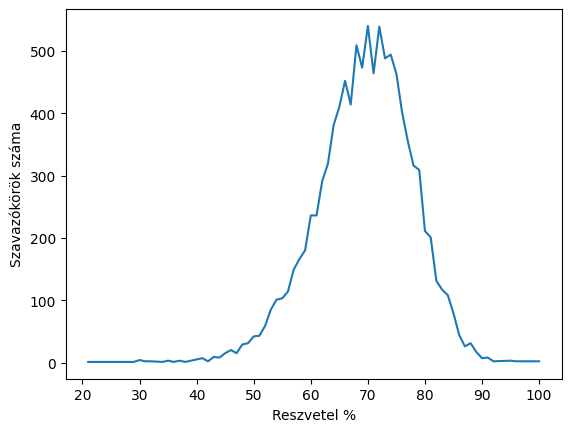

In [65]:
# teljes reszvetel
calculate_frequency(eredmenyek_osszes['reszvetel']).plot(xlabel='Reszvetel %', ylabel='Szavazókörök száma')

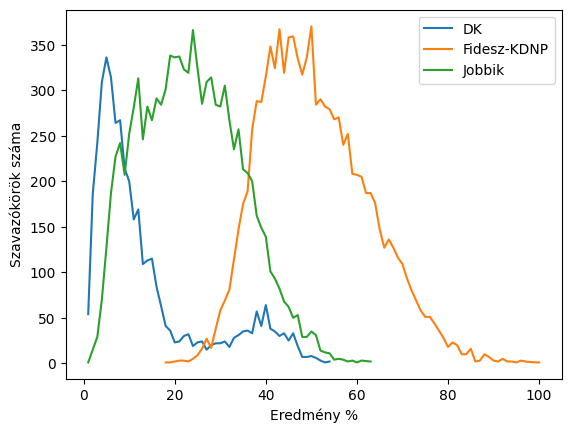

In [80]:
# egyeni szavazatok összes
calculate_frequency(eredmenyek_osszes['dk']).plot()
calculate_frequency(eredmenyek_osszes['fidesz-kdnp']).plot()
calculate_frequency(eredmenyek_osszes['jobbik']).plot(xlabel='Eredmény %', ylabel='Szavazókörök száma').legend(['DK','Fidesz-KDNP', 'Jobbik'])

In [99]:
# Szavazókörök eredményei Marcali
marcali = eredmenyek_osszes[eredmenyek_osszes['szavazokor'].str.contains("Marcali")].sort_values(by=['reszvetel'])
display(marcali[['szavazokor','tipus', 'teljes', 'szavazott', 'ervenyes', 'reszvetel', 'fidesz-kdnp', 'jobbik', 'mszp-p']])

,szavazokor,tipus,teljes,szavazott,ervenyes,reszvetel,fidesz-kdnp,jobbik,mszp-p
3615,Marcali 012,normal,285,173,170,60.70,75.294118,15.294118,8.235294
3621,Marcali 001,normal,1008,633,626,62.80,45.686901,44.728435,7.348243
3625,Marcali 007,normal,1134,727,486,64.11,49.382716,40.329218,8.847737
3618,Marcali 009,normal,1122,725,716,64.62,45.810056,46.089385,7.402235
3616,Marcali 004,normal,1179,764,760,64.80,39.342105,48.421053,9.736842
3623,Marcali 010,normal,387,251,248,64.86,57.258065,36.693548,4.838710
3614,Marcali 008,egyszavazokoros,780,517,512,66.28,39.062500,51.367188,6.835938
3620,Marcali 003,normal,892,640,637,71.75,38.147567,46.781790,13.500785
3624,Marcali 011,normal,78,56,56,71.79,42.857143,48.214286,7.142857
3617,Marcali 005,normal,1111,798,792,71.83,38.383838,46.969697,12.373737


In [84]:
print(eredmenyek_osszes['tipus'].value_counts())

tipus
normal             7002
egyszavazokoros    3177
atjelentkezeses     106
Name: count, dtype: int64
